In [2]:
import numpy as np
import math    

import numpy as np
from itertools import chain
import math

class Automata:
    def __init__(self, transition_matrix, rewards, finish_states, start_state, alphabet, alphabet_costs):       # transition matrix должна быть размера nxnxm, 
        self.transition_matrix = transition_matrix                                              # где n - количество состояний автомата,
        self.rewards = rewards                                                                  # а m - количество букв в алфавите, который принимает автомат
        self.finish_states = finish_states                                                      # для нашего автомата важно, что сумма элементов сечения
        self.start_state = start_state                                                          # по каждой букве (то есть вероятность перехода из i-го
        self.current_state = start_state                                                        # состояния по букве a в какое-то любое j-е равна 1)
        self.size = len(self.transition_matrix[0][0])
        self.costs = alphabet_costs
        letter_map = {}
        j = 0
        for i in alphabet:
            letter_map[i] = j
            j += 1
        self.alphabet = letter_map                                                              # алфавит в порядке того, как записаны матрицы в transiton_matrix
  #     self.letters_size = len(self.transition_matrix)                                         # буквы будут любые, но соответствие будет такое: буквы идут в порядке, в соответствии с которым записаны матрицы в transition_matrix
        self.letters_size = len(letter_map)
        
    def transition(self, letter):
        elements = np.arange(self.size)
        probabilities = self.transition_matrix[self.alphabet[letter]][self.current_state]
        self.current_state = np.random.choice(elements, 1, p=probabilities)[0]
        return self

    def change_state(self, state):
        self.current_state = state
        return self
        
    def word_result(self, word):
        result = 0
        for i in word:
#            if (self.current_state in self.finish_states):       -- возможно, так тоже будем делать, это сократит сильно количество допустимых вариантов
#                break
            self = self.transition(i)
        result = self.rewards[self.current_state]
        return result

    def word_result_automata_back(self, word):
        result = 0
        begin_state = self.current_state
        for i in word:
#            if (self.current_state in self.finish_states):       -- возможно, так тоже будем делать, это сократит сильно количество допустимых вариантов
#                break
            self = self.transition(i)
        result = self.rewards[self.current_state]
        self = self.change_state(begin_state)
        return result

    def word_expectation(self, word):
        p_start = np.zeros(self.size)
        p_start[self.start_state] = 1
        cost = 0
        for i in word:
            p_start = np.dot(p_start, np.array(self.transition_matrix[self.alphabet[i]]))
            cost += self.costs[self.alphabet[i]]
        state_probabilities = p_start
        expectation = np.dot(p_start, self.rewards) - cost
        return (state_probabilities, expectation)
        

In [93]:
# АЛГОРИТМ (Полный перебор)
import time
import itertools

import random

def exhaustive_research(automata, n):
    start_time = time.time()
    alphabet = list(automata.alphabet.keys())
    max_result = float('-inf')  # Начальное значение для максимального результата
    max_word = None  # Переменная для хранения слова, дающего максимальный результат
    
    # Генерируем все возможные комбинации слов длины n из алфавита
    word_combinations = itertools.product(alphabet, repeat=n)
    
    # Перебираем все комбинации слов
    for word in word_combinations:
        # Преобразуем слово из кортежа в строку
        word_str = ''.join(word)
        # Вычисляем результат для текущего слова с помощью функции func
        result = automata.word_expectation(word_str)[1]
        # Если результат больше максимального, обновляем максимальный результат и слово
        if result > max_result:
            max_result = result
            max_word = word_str
    run_time = time.time() - start_time
    return (max_word, max_result, run_time)


# exhaustive_research ТЕСТ
# exhaustive_research ТЕСТ
# exhaustive_research ТЕСТ

# print(exhaustive_research(automata, 10))

###############################

def generate_random_word(alphabet, n):
    random_word = ''.join(random.choice(alphabet) for _ in range(n))
    return random_word

def elite_algorithm(automata, n, k, iterations, number_of_words):
    start_time = time.time()
    alphabet = list(automata.alphabet.keys())
    words_massive = []
    
    num_selected = int(number_of_words * (1 - k))
    num_replace = number_of_words - num_selected
    
    for j in range(number_of_words):
        words_massive.append(generate_random_word(alphabet, n))
        
    for i in range(iterations):
        func_results = {word: automata.word_expectation(word)[1] for word in words_massive}
        sorted_words = sorted(words_massive, key=lambda x: func_results[x], reverse=True)
        selected_words = sorted_words[:num_selected]

        words_to_replace = []
        for j in range(num_replace):
            words_to_replace.append(generate_random_word(alphabet, n))
        words_massive = selected_words + words_to_replace
    
    func_results = {word: automata.word_expectation(word)[1] for word in words_massive}
    sorted_words = sorted(words_massive, key=lambda x: func_results[x], reverse=True)
    run_time = time.time() - start_time
    return (sorted_words[0], automata.word_expectation(sorted_words[0])[1], run_time)
    
# print(elite_algorithm(automata, 9, 0.5, 1000, 10))

#############################################


# Параметры генетического алгоритма
population_size = 10 # Размер популяции
word_length = 9      # Длина каждого слова
generations = 1000    # Количество поколений
mutation_rate = 0.1   # Вероятность мутации
how_many_from_old_population = 6
#word_expectation - value слова
def fitness(automata, word):
    return automata.word_expectation(word)[1]

# функция создания популяции
def initialize_population(size, length, alphabet):
    return [''.join(random.choice(alphabet) for _ in range(length)) for _ in range(size)]

def select_pair(population):
    return random.sample(population, 2)

def crossover_vol1(word1, word2):
    point = random.randint(1, len(word1) - 1)
    new_word1 = word1[:point] + word2[point:]
    new_word2 = word2[:point] + word1[point:]
    return new_word1, new_word2

def mutate_vol1(word, mutation_rate, alphabet):
    if random.random() < mutation_rate:
        index = random.randint(0, len(word) - 1)
        new_char = random.choice(alphabet)
        word = word[:index] + new_char + word[index + 1:]
    return word

### Алгоритм с кроссоверами. Вариант 1
def evolutionary(automata, population_size, word_length, alphabet, generations, mutation_rate, how_many_from_old_population):
    
    population = initialize_population(population_size, word_length, alphabet)
    start_time = time.time()
    for generation in range(generations):
        # Оцениваем популяцию
        scored_population = [(word, fitness(automata, word)) for word in population]
        scored_population.sort(key=lambda x: x[1], reverse=True)
    
        # Сохраняем лучшие результаты
        new_population = [word for word, score in scored_population[:how_many_from_old_population]]
    
        # Кроссовер и мутация для заполнения оставшейся части популяции
        while len(new_population) < population_size:
            parent1, parent2 = select_pair(population)
            child1, child2 = crossover_vol1(parent1, parent2)
            new_population.extend([mutate_vol1(child1, mutation_rate, alphabet), mutate_vol1(child2, mutation_rate, alphabet)])
    
        population = new_population
    
        # Выводим лучший результат каждого поколения
        # print(f'Generation {generation + 1}: Best Score = {scored_population[0][1]}, Word = {scored_population[0][0]}')
        
    run_time = time.time() - start_time
    # print(select_pair(new_population))
    return(scored_population[0][0], scored_population[0][1], run_time)
    

###############################################################

# Параметры генетического алгоритма
population_size = 10 # Размер популяции
word_length = 8      # Длина каждого слова
generations = 1000    # Количество поколений
mutation_rate = 0.1   # Вероятность мутации
how_many_from_old_population = 6

num_func_crossover = 2
num_func_mutate = 1
#word_expectation - value слова
def fitness(automata, word):
    return automata.word_expectation(word)[1]

# функция создания популяции
def initialize_population(size, length, alphabet):
    return [''.join(random.choice(alphabet) for _ in range(length)) for _ in range(size)]

def select_pair(population):
    return random.sample(population, 2)

# def crossover1(word1, word2, automata, word_length):
#     score1 = fitness(automata, word1)
#     score2 = fitness(automata, word2)
#     point = random.randint(0, word_length - 1)
#     if (score1 > score2):
#         point = random.randint(0, word_length - 1)

def crossover1(word1, word2, word_length): # обмен экспертизой
    point = random.randint(0, word_length - 1)
    list1 = list(word1)
    list2 = list(word2)
    letter1 = list1[point]
    letter2 = list2[point]
    list1[point] = letter2
    list2[point] = letter1
    child1 = ''.join(list1)
    child2 = ''.join(list2)
    return child1, child2

# def crossover2(word1, word2, word_length): # апробация новой стратегии
#     point = random.randint(1, len(word1) - 1)
#     new_word1 = word1[:point] + word2[point:]
#     new_word2 = word2[:point] + word1[point:]
#     return new_word1, new_word2

def crossover3(word1, word2, word_length):
    cp1 = list(word1)
    cp2 = list(word2)
    child1 = []
    child2 = []
    for i in range(word_length):
        if (i % 2 == 0):
            child2.append(word1[i])
            child1.append(word2[i])
        else:
            child2.append(word2[i])
            child1.append(word1[i])

    return1 = ''.join(child1)
    return2 = ''.join(child2)
    return return1, return2
        
def crossover_vol2(word1, word2, word_length):
    seq = [i + 1 for i in range(num_func_crossover)]
    dice = random.choice(seq)
    
    if (dice == 1):
        return crossover1(word1, word2, word_length)
    elif (dice == 2):
        return crossover3(word1, word2, word_length)
    # elif (dice == 3):
    #     return crossover3(word1, word2, word_length)

def mutate1(word, mutation_rate, alphabet, index, special_symbol):
    if random.random() < mutation_rate:
        index = random.randint(0, len(word) - 1)
        new_char = random.choice(alphabet)
        word = word[:index] + new_char + word[index + 1:]
    return word
# def mutate2(word, mutation_rate, alphabet, index, special_symbol):
#     if random.random() < mutation_rate:
#         list_word = list(word)
#         list_word[index] = special_symbol
#         word = ''.join(list_word)
#     return word
        
def mutate_vol2(word, mutation_rate, alphabet, index, special_symbol):
    seq = [i + 1 for i in range(num_func_mutate)]
    dice = random.choice(seq)
    if (dice == 1):
        # return mutate1(word, mutation_rate, alphabet)
        return mutate1(word, mutation_rate, alphabet, index, special_symbol)
    # if (dice == 2):
    #     return mutate2(word, mutation_rate, alphabet, index, special_symbol)

def evolutionary_vol2(automata, population_size, word_length, alphabet, generations, mutation_rate, how_many_from_old_population):
    
    population = initialize_population(population_size, word_length, alphabet)
    start_time = time.time()
    for generation in range(generations):
        # Оцениваем популяцию
        scored_population = [(word, fitness(automata, word)) for word in population]
        scored_population.sort(key=lambda x: x[1], reverse=True)
    
        # Сохраняем лучшие результаты
        new_population = [word for word, score in scored_population[:how_many_from_old_population]]
    
        # Кроссовер и мутация для заполнения оставшейся части популяции
        while len(new_population) < population_size:
            index = random.randint(0, word_length - 1)
            special_symbol = scored_population[0][0][index]
            parent1, parent2 = select_pair(population)
            child1, child2 = crossover_vol2(parent1, parent2, word_length)
            new_population.extend([mutate_vol2(child1, mutation_rate, alphabet, index, special_symbol), mutate_vol2(child2, mutation_rate, alphabet, index, special_symbol)])
    
        population = new_population
    
        # Выводим лучший результат каждого поколения
        # print(f'Generation {generation + 1}: Best Score = {scored_population[0][1]}, Word = {scored_population[0][0]}')
        
    run_time = time.time() - start_time
    # print(select_pair(new_population))
    return(scored_population[0][0], scored_population[0][1], run_time)

# print(exhaustive_research(automata, 10))

### Новый ген алгоритм

# Параметры генетического алгоритма
population_size = 10 # Размер популяции
word_length = 8      # Длина каждого слова
generations = 1000    # Количество поколений
mutation_rate = 0.1   # Вероятность мутации
how_many_from_old_population = 6

num_func_crossover = 1
num_func_mutate = 1
#word_expectation - value слова
def fitness(automata, word):
    return automata.word_expectation(word)[1]

# функция создания популяции
def initialize_population(size, length, alphabet):
    return [''.join(random.choice(alphabet) for _ in range(length)) for _ in range(size)]

def select_for_crossover(population, crossover_group):
    return random.sample(population, crossover_group)


def crossover1_vol3(group, word_length, alphabet): # обмен экспертизой
    new_word = []
    for i in range(word_length):
        map_letters = {}
        for k in alphabet:
            map_letters[k] = 0
        for j in range(len(group)):
            map_letters[group[j][i]] += 1
        probabilities = []
        for k in alphabet:
            map_letters[k] /= len(group)
            probabilities.append(map_letters[k])
        new_letter_random = np.random.choice(len(alphabet), 1, p=probabilities)[0]
        new_word.append(alphabet[new_letter_random])
    return ''.join(new_word)
            
        


        
def crossover_vol3(group, word_length, alphabet):
    seq = [i + 1 for i in range(num_func_crossover)]
    dice = random.choice(seq)
    if (dice == 1):
        return crossover1_vol3(group, word_length, alphabet)


def mutate1_vol3(word, mutation_rate, alphabet):
    if random.random() < mutation_rate:
        index = random.randint(0, len(word) - 1)
        new_char = random.choice(alphabet)
        word = word[:index] + new_char + word[index + 1:]
    return word

        
def mutate_vol3(word, mutation_rate, alphabet):
    seq = [i + 1 for i in range(num_func_mutate)]
    dice = random.choice(seq)
    if (dice == 1):
        # return mutate1(word, mutation_rate, alphabet)
        return mutate1_vol3(word, mutation_rate, alphabet)
        
def evolutionary_vol3(automata, population_size, word_length, alphabet, generations, mutation_rate, how_many_from_old_population, crossover_group):
    
    population = initialize_population(population_size, word_length, alphabet)
    start_time = time.time()
    for generation in range(generations):
        # Оцениваем популяцию
        scored_population = [(word, fitness(automata, word)) for word in population]
        scored_population.sort(key=lambda x: x[1], reverse=True)
    
        # Сохраняем лучшие результаты
        new_population = [word for word, score in scored_population[:how_many_from_old_population]]
    
        # Кроссовер и мутация для заполнения оставшейся части популяции
        while len(new_population) < population_size:
            group = select_for_crossover(population, crossover_group)
            child = crossover_vol3(group, word_length, alphabet)
            new_population.extend([mutate_vol3(child, mutation_rate, alphabet)])
    
        population = new_population
    
        # Выводим лучший результат каждого поколения
        # print(f'Generation {generation + 1}: Best Score = {scored_population[0][1]}, Word = {scored_population[0][0]}')
        
    run_time = time.time() - start_time
    # print(select_pair(new_population))
    return(scored_population[0][0], scored_population[0][1], run_time)

crossover_group = 10
num_words = 10

print(elite_algorithm(automata4, word_length, 0.5, 1000, 10))

print(evolutionary(automata4, population_size, word_length, list(automata4.alphabet.keys()), generations, mutation_rate, how_many_from_old_population))

print(evolutionary_vol2(automata4, population_size, word_length, list(automata4.alphabet.keys()), generations, mutation_rate, how_many_from_old_population))

print(evolutionary_vol3(automata4, population_size, word_length, list(automata4.alphabet.keys()), generations, mutation_rate, how_many_from_old_population, crossover_group))

('eeaaebbe', 37.42999999999999, 0.22355437278747559)
('eeeaeabb', 37.42999999999999, 0.24210476875305176)
('aeeaeebb', 37.42999999999999, 0.259904146194458)
('eeaaeebb', 37.42999999999999, 0.6255223751068115)


In [94]:
### функция сравнивающая все алгоритмы на автомате
import statistics
import numpy as np

def comparison(automata, word_length, generations, alphabet, num_words, mutation_rate, how_many_from_old_population, precision, k, crossover_group):
    sum_elite = []
    sum_gen1 = []
    sum_gen2 = []
    sum_gen3 = []

    for i in range(precision):
        sum_elite.append(elite_algorithm(automata, word_length, k, generations, num_words)[1])
        sum_gen1.append(evolutionary(automata, num_words, word_length, list(automata.alphabet.keys()), generations, mutation_rate, how_many_from_old_population)[1])
        sum_gen2.append(evolutionary_vol2(automata, num_words, word_length, list(automata.alphabet.keys()), generations, mutation_rate, how_many_from_old_population)[1])
        sum_gen3.append(evolutionary_vol3(automata, num_words, word_length, alphabet, generations, mutation_rate, how_many_from_old_population, crossover_group)[1])

    map_res = {}
    map_res['elite'] = (round(statistics.mean(sum_elite), 2), round(np.std(sum_elite), 2))
    map_res['gen1'] = (round(statistics.mean(sum_gen1), 2), round(np.std(sum_gen1), 2))
    map_res['gen2'] = (round(statistics.mean(sum_gen2), 2), round(np.std(sum_gen2), 2))
    map_res['gen3'] = (round(statistics.mean(sum_gen3), 2), round(np.std(sum_gen3), 2))

    return map_res

automata = automata4
word_length = 15
generations = 100
num_words = 10
mutation_rate = 0.1
how_many_from_old_population = 6
precision = 60
k = 0.5
crossover_group = int(num_words / 2)

map = comparison(automata4, word_length, generations, list(automata4.alphabet.keys()), num_words, mutation_rate, how_many_from_old_population, precision, k, crossover_group)

print(map['elite'])
print('\n')
print(map['gen1'])
print('\n')
print(map['gen2'])
print('\n')
print(map['gen3'])

(30.3, 3.36)


(34.57, 4.13)


(34.18, 3.74)


(36.73, 1.68)


In [5]:
# Автомат #4 (Симулирует реальный кейс)

alphabet4 = ['a', 'b', 'e']
# alphabet4 = ['a', 'b']
rewards4 = [0, 0, 0, 0, 0, 100]
transition_matrix4 = [
    [ # - a
        
            [1, 0, 0, 0, 0, 0],
            [0.4, 0.4, 0, 0.2, 0, 0],
            [0, 0.2, 0.3, 0.5, 0, 0],
            [0, 0, 0.1, 0.4, 0.4, 0.1],
            [0, 0, 0.2, 0.1, 0.3, 0.4],
            [0.1, 0.2, 0, 0, 0, 0.7]
        
    ],
    [ # - b
         
            [1, 0, 0, 0, 0, 0],
            [0.2, 0.5, 0, 0.3, 0, 0],
            [0, 0.2, 0.3, 0.3, 0.2, 0],
            [0, 0, 0, 0.3, 0.4, 0.3],
            [0, 0, 0, 0, 0.1, 0.9],
            [0.1, 0.2, 0, 0, 0, 0.7]
         
    ],
    [ # - e
        
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1]
    ]
]

# АВТОМАТ 5 - Вредный чел
alphabet5 = ['a', 'b', 'e']
# alphabet5 = ['a', 'b']
rewards5 = [0, 0, 0, 0, 0, 100]
transition_matrix5 = [
    [ # - a
        
            [1, 0, 0, 0, 0, 0],
            [0.5, 0.4, 0, 0.1, 0, 0],
            [0, 0.4, 0.3, 0.3, 0, 0],
            [0.2, 0.1, 0, 0.4, 0.2, 0.1],
            [0, 0, 0.2, 0.1, 0.4, 0.3],
            [0.1, 0.2, 0, 0, 0, 0.7]
        
    ],
    [ # - b
         
            [1, 0, 0, 0, 0, 0],
            [0, 0.7, 0, 0.3, 0, 0],
            [0, 0.1, 0.4, 0.4, 0.1, 0],
            [0, 0.1, 0, 0, 0.4, 0.5],
            [0, 0, 0, 0, 0.2, 0.8],
            [0.1, 0.1, 0, 0, 0, 0.8]
         
    ],
    [ # - e
        
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1]
    ]
]

automata7 = Automata(transition_matrix5, rewards5, [0], 3, alphabet5, [0.1, 5, 0])

automata6 = Automata(transition_matrix4, rewards4, [0], 3, alphabet4, [0.1, 5, 0])

automata5 = Automata(transition_matrix5, rewards5, [0], 2, alphabet5, [0.1, 5, 0])

automata4 = Automata(transition_matrix4, rewards4, [0], 2, alphabet4, [0.1, 5, 0])

In [6]:
transition_matrix4 = [
    [ # - a
        
            [1, 0, 0, 0, 0, 0],
            [0.4, 0.4, 0, 0.2, 0, 0],
            [0, 0.2, 0.3, 0.5, 0, 0],
            [0, 0, 0.1, 0.4, 0.4, 0.1],
            [0, 0, 0.2, 0.1, 0.3, 0.4],
            [0.1, 0.2, 0, 0, 0, 0.7]
        
    ],
    [ # - b
         
            [1, 0, 0, 0, 0, 0],
            [0.2, 0.5, 0, 0.3, 0, 0],
            [0, 0.2, 0.3, 0.3, 0.2, 0],
            [0, 0, 0, 0.3, 0.4, 0.3],
            [0, 0, 0, 0, 0.1, 0.9],
            [0.1, 0.2, 0, 0, 0, 0.7]
         
    ],
    [ # - e
        
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1]
    ]
]
def normalize(v):
    sum_v = sum(v)
    for i in range(len(v)):
        v[i] /= sum_v
    return v
    
def generate_automata_class1():
    list_a = [
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0.1, 0.2, 0, 0, 0, 0.7]
    ]
    list_b = [
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0.1, 0.2, 0, 0, 0, 0.7]
    ]
    list_e = [ # - e
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ]
    
    indexex_a = [[0, 1, 3], [1, 2, 3], [2, 3, 4, 5], [2, 3, 4, 5]]
    indexex_b = [[0, 1, 3], [1, 2, 3, 4], [3, 4, 5], [4, 5]]

    parameters_vector = []
    
    for i in range(len(indexex_a)):
        for j in range(len(indexex_a[i])):
            list_a[i + 1][indexex_a[i][j]] = round(random.uniform(0, 1), 2)
            parameters_vector.append(list_a[i + 1][indexex_a[i][j]])
            
    for i in range(len(indexex_b)):
        for j in range(len(indexex_b[i])):
            list_b[i + 1][indexex_b[i][j]] = round(random.uniform(0, 1), 2)
            parameters_vector.append(list_b[i + 1][indexex_b[i][j]])
            
    for i in range(len(list_a)):
        list_a[i] = normalize(list_a[i])

    for i in range(len(list_b)):
        list_b[i] = normalize(list_b[i])

    transition_matrix = [list_a, list_b, list_e]
    return (Automata(transition_matrix, [0, 0, 0, 0, 0, 100], [0], 2, ['a', 'b', 'e'], [0.1, 5, 0]), parameters_vector)

def generate_automata_class2():
    list_a = [
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0.1, 0.2, 0, 0, 0, 0.7]
    ]
    list_b = [
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0.1, 0.1, 0, 0, 0, 0.8]
    ]
    list_e = [ # - e
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ]
    
    indexex_a = [[0, 1, 4], [1, 2, 3], [0, 1, 3, 4, 5], [2, 3, 4, 5]]
    indexex_b = [[1, 3], [1, 2, 3, 4], [1, 4, 5], [4, 5]]

    parameters_vector = []
    
    for i in range(len(indexex_a)):
        for j in range(len(indexex_a[i])):
            list_a[i + 1][indexex_a[i][j]] = round(random.uniform(0, 1), 2)
            parameters_vector.append(list_a[i + 1][indexex_a[i][j]])
            
    for i in range(len(indexex_b)):
        for j in range(len(indexex_b[i])):
            list_b[i + 1][indexex_b[i][j]] = round(random.uniform(0, 1), 2)
            parameters_vector.append(list_b[i + 1][indexex_b[i][j]])
            
    for i in range(len(list_a)):
        list_a[i] = normalize(list_a[i])

    for i in range(len(list_b)):
        list_b[i] = normalize(list_b[i])
    transition_matrix = [list_a, list_b, list_e]


    return (Automata(transition_matrix, [0, 0, 0, 0, 0, 100], [0], 2, ['a', 'b', 'e'], [0.1, 5, 0]), parameters_vector)

    
automata_list = [generate_automata_class1() for i in range(1000)]
automata_list[0][1]
# automata_list = [generate_automata_class2() for i in range(400)]

[0.67,
 0.1,
 0.3,
 0.85,
 0.94,
 0.8,
 0.72,
 0.71,
 0.76,
 0.42,
 0.03,
 0.86,
 0.83,
 0.12,
 0.05,
 0.35,
 0.58,
 0.28,
 0.3,
 0.23,
 0.6,
 0.2,
 0.62,
 0.37,
 0.35,
 0.25]

In [124]:
import pandas as pd
from tabulate import tabulate
from IPython.display import display, HTML
import time

word_length = 10
generations = 10
num_words = 10
mutation_rate = 0.1
how_many_from_old_population = 6
precision = 150
k = 0.5
crossover_group = int(num_words / 2)
c = 1
list_exhaustive = []
list_elite = []
list_gen1 = []
list_gen2 = []
list_gen3 = []
df = pd.DataFrame({'automata_no': [], 'elite': [], 'gen1': [], 'gen2': [], 'gen3': []})
start_time = time.time()
for automata in automata_list:
    
    map = comparison(automata, word_length, generations, list(automata.alphabet.keys()), num_words, mutation_rate, how_many_from_old_population, precision, k, crossover_group)
    print(f'выполнено {c}, времени затрачено:', time.time() - start_time)
    list_elite.append((map['elite'][0], map['elite'][1]))
    list_gen1.append((map['gen1'][0], map['gen1'][1]))
    list_gen2.append((map['gen2'][0], map['gen2'][1]))
    list_gen3.append((map['gen3'][0], map['gen3'][1]))
    list_exhaustive.append(exhaustive_research(automata, 10)[1])
    df.loc[len(df.index)] = [f'automata{c}', str(map['elite'][0]) + '+-' + str(map['elite'][1]), str(map['gen1'][0]) + '+-' + str(map['gen1'][1]), str(map['gen2'][0]) + '+-' + str(map['gen2'][1]), str(map['gen3'][0]) + '+-' + str(map['gen3'][1])] 
    c+= 1



выполнено 1, времени затрачено: 0.8820631504058838
выполнено 2, времени затрачено: 3.2487545013427734
выполнено 3, времени затрачено: 5.495487451553345
выполнено 4, времени затрачено: 7.792967319488525
выполнено 5, времени затрачено: 10.107446908950806
выполнено 6, времени затрачено: 12.360665082931519
выполнено 7, времени затрачено: 14.61051344871521
выполнено 8, времени затрачено: 16.944753170013428
выполнено 9, времени затрачено: 19.269862174987793
выполнено 10, времени затрачено: 21.564486503601074
выполнено 11, времени затрачено: 23.830063581466675
выполнено 12, времени затрачено: 26.129042148590088
выполнено 13, времени затрачено: 28.4897677898407
выполнено 14, времени затрачено: 30.760587692260742
выполнено 15, времени затрачено: 33.01706504821777
выполнено 16, времени затрачено: 35.315998792648315
выполнено 17, времени затрачено: 37.66487717628479
выполнено 18, времени затрачено: 39.98430037498474
выполнено 19, времени затрачено: 42.387999296188354
выполнено 20, времени затраче

KeyboardInterrupt: 

In [108]:
html = tabulate(df, headers='keys', tablefmt='html', showindex=False)


display(HTML(html))

automata_no,elite,gen1,gen2,gen3
automata1,37.93+-2.78,39.43+-2.01,38.68+-2.73,38.79+-2.81
automata2,14.64+-1.24,14.07+-1.7,13.53+-2.53,14.57+-1.98
automata3,18.72+-2.87,18.08+-3.48,16.31+-4.14,18.93+-3.24
automata4,25.95+-1.11,25.89+-1.8,25.52+-2.31,26.28+-1.22
automata5,31.14+-4.51,31.23+-6.09,29.61+-6.18,32.57+-4.86
automata6,20.94+-1.07,20.46+-1.85,20.34+-1.81,21.1+-1.3
automata7,36.39+-4.15,35.71+-5.32,34.59+-5.32,37.24+-4.67
automata8,46.67+-4.67,44.85+-6.52,44.98+-5.95,47.48+-4.33
automata9,27.03+-1.08,26.95+-1.32,26.31+-1.94,27.25+-1.02
automata10,26.35+-4.23,27.34+-3.62,25.42+-4.62,28.36+-3.16


In [109]:
print(list_elite)
print('\n\n\n')
print(list_gen1)
print('\n\n\n')
print(list_gen2)
print('\n\n\n')
print(list_gen3)
print('\n\n\n')
print(list_exhaustive)

[(37.93, 2.78), (14.64, 1.24), (18.72, 2.87), (25.95, 1.11), (31.14, 4.51), (20.94, 1.07), (36.39, 4.15), (46.67, 4.67), (27.03, 1.08), (26.35, 4.23), (28.88, 0.58), (19.32, 1.54), (40.59, 1.77), (23.73, 0.64), (36.98, 1.58), (33.35, 1.26), (21.32, 0.6), (38.58, 4.21), (36.48, 0.88), (31.13, 1.46), (12.37, 0.26), (18.35, 2.17), (19.4, 1.06), (31.08, 3.38), (38.61, 5.05), (31.58, 0.68), (30.67, 2.45), (21.06, 1.03), (30.34, 1.69), (24.92, 1.25), (11.03, 0.56), (17.18, 0.84), (6.35, 0.79), (30.4, 2.85), (27.71, 1.49), (36.53, 0.73), (20.25, 1.7), (11.35, 0.17), (31.21, 3.84), (25.45, 1.64), (28.3, 1.47), (22.71, 1.47), (30.64, 1.59), (32.72, 0.65), (28.24, 2.03), (15.78, 0.58), (22.64, 0.62), (12.72, 2.17), (28.95, 2.09), (31.88, 4.98), (31.24, 1.0), (25.1, 1.72), (13.1, 1.91), (28.38, 2.41), (32.22, 1.03), (41.58, 3.43), (30.99, 0.62), (24.36, 0.37), (20.05, 1.11), (30.46, 2.5), (8.98, 1.01), (15.15, 1.49), (20.97, 1.29), (15.25, 0.69), (30.36, 2.29), (17.04, 0.44), (32.27, 1.83), (18.1

In [110]:
list_elite_e = [i[0] for i in list_elite]
list_gen1_e = [i[0] for i in list_gen1]
list_gen2_e = [i[0] for i in list_gen2]
list_gen3_e = [i[0] for i in list_gen3]

print(statistics.mean(list_elite_e))
print('\n')
print(statistics.mean(list_gen1_e))
print('\n')
print(statistics.mean(list_gen2_e))
print('\n')
print(statistics.mean(list_gen3_e))
print('\n')
print(statistics.mean(list_exhaustive))

26.6603


26.3775


25.9239


26.9995


28.27998679411123


In [117]:
df_copy_3000

,automata_no,elite,gen1,gen2,gen3
0,automata1,20.11+-0.56,19.86+-1.32,19.47+-1.68,20.36+-0.46
1,automata2,30.32+-0.72,30.41+-1.61,29.39+-2.82,30.96+-0.23
2,automata3,30.78+-0.67,30.68+-1.14,30.33+-1.3,31.04+-0.52
3,automata4,28.51+-1.48,29.08+-1.96,28.94+-1.92,30.24+-1.29
4,automata5,33.44+-2.25,31.63+-4.84,31.61+-5.1,34.62+-1.87
...,...,...,...,...,...
2995,automata2996,27.87+-1.92,27.8+-2.75,27.26+-2.49,28.4+-2.13
2996,automata2997,28.09+-2.6,26.81+-3.85,25.99+-3.86,29.18+-3.35
2997,automata2998,19.33+-2.15,20.04+-2.5,18.65+-3.28,20.9+-1.52
2998,automata2999,29.09+-2.95,30.27+-4.33,29.17+-3.94,33.12+-2.63


In [112]:
rel_el = []
rel_gen1 = []
rel_gen2 = []
rel_gen3 = []
for i in range(100):
    if(list_elite_e[i] > 0 and list_gen1_e[i] > 0 and list_gen2_e[i] > 0 and list_gen3_e[i] > 0 and list_exhaustive[i] > 0):
        rel_el.append(100 * float(list_elite_e[i] / list_exhaustive[i]))
        rel_gen1.append(100 * float(list_gen1_e[i] / list_exhaustive[i]))
        rel_gen2.append(100 * float(list_gen2_e[i] / list_exhaustive[i]))
        rel_gen3.append(100 * float(list_gen3_e[i] / list_exhaustive[i]))

print(statistics.mean(rel_el))
print(statistics.mean(rel_gen1))
print(statistics.mean(rel_gen2))
print(statistics.mean(rel_gen3))


94.2188740822191
92.86784269942969
91.31592309133424
95.11849835261997


In [8]:
import numpy as np
from scipy.linalg import block_diag
from itertools import chain

def union_automatas(automata_list, probabilities):
    size = len(automata_list)
    rewards = []
    for i in range(size):
        rewards.append(automata_list[i].rewards)
    flat_rewards = list(chain.from_iterable(rewards))
    flat_rewards.insert(0, 0.0)
    start_state = 0
    alphabet = automata_list[0].alphabet
    states_count = 0
    costs = automata_list[0].costs
    for i in range(size):
        states_count += automata_list[i].size
    finish_states = [i for i in range(states_count)]
    transition_matrix_list = []
    for i in range(len(automata_list[0].alphabet)):
        transition_matrix_pieces = [[0]]
        for j in range(size):
            transition_matrix_pieces.append(automata_list[j].transition_matrix[i])
        transition_matrix_list.append(block_diag(*transition_matrix_pieces))
    transition_matrix_list = np.array(transition_matrix_list)
    transition_matrix_list = transition_matrix_list.astype(float)
    for i in range(len(automata_list[0].alphabet)):
        new_line = []
        for j in range(0, size):
            new_line.append(np.multiply(probabilities[j], automata_list[j].transition_matrix[i][automata_list[j].start_state]))
        flat_list = list(chain.from_iterable(new_line))
        flat_list.insert(0, 0.0)
        transition_matrix_list[i][0] = flat_list

    automata = Automata(transition_matrix_list, flat_rewards, finish_states, start_state, alphabet, costs)
    return automata

In [9]:
def normalize(v):
    sum_v = sum(v)
    for i in range(len(v)):
        v[i] /= sum_v
    return v
    
def generate_automata_class1():
    list_a = [
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0.1, 0.2, 0, 0, 0, 0.7]
    ]
    list_b = [
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0.1, 0.2, 0, 0, 0, 0.7]
    ]
    list_e = [ # - e
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ]
    
    indexex_a = [[0, 1, 3], [1, 2, 3], [2, 3, 4, 5], [2, 3, 4, 5]]
    indexex_b = [[0, 1, 3], [1, 2, 3, 4], [3, 4, 5], [4, 5]]

    # parameters_vector = []
    
    for i in range(len(indexex_a)):
        for j in range(len(indexex_a[i])):
            list_a[i + 1][indexex_a[i][j]] = round(random.uniform(0, 1), 2)
            # parameters_vector.append(list_a[i + 1][indexex_a[i][j]])
            
    for i in range(len(indexex_b)):
        for j in range(len(indexex_b[i])):
            list_b[i + 1][indexex_b[i][j]] = round(random.uniform(0, 1), 2)
            # parameters_vector.append(list_b[i + 1][indexex_b[i][j]])
            
    for i in range(len(list_a)):
        list_a[i] = normalize(list_a[i])

    for i in range(len(list_b)):
        list_b[i] = normalize(list_b[i])

    transition_matrix = [list_a, list_b, list_e]
    automata1 = Automata(transition_matrix, [0, 0, 0, 0, 0, 100], [0], 1, ['a', 'b', 'e'], [0.1, 5, 0])
    automata2 = Automata(transition_matrix, [0, 0, 0, 0, 0, 100], [0], 2, ['a', 'b', 'e'], [0.1, 5, 0])
    automata3 = Automata(transition_matrix, [0, 0, 0, 0, 0, 100], [0], 3, ['a', 'b', 'e'], [0.1, 5, 0])
    automata4 = Automata(transition_matrix, [0, 0, 0, 0, 0, 100], [0], 4, ['a', 'b', 'e'], [0.1, 5, 0])

    return union_automatas([automata1, automata2, automata3, automata4], [0.25, 0.25, 0.25, 0.25])

automata_list = [generate_automata_class1() for i in range(300)]

In [10]:
automata_list[0]

In [163]:
import pandas as pd
# generations_razbivka = [5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40]
generations_razbivka = [45, 50, 55, 60]

# automata_list = [generate_automata_class2() for i in range(30)]
word_length = 10
generations = 10
num_words = 10
mutation_rate = 0.1
how_many_from_old_population = 6
precision = 50
k = 0.5
crossover_group = int(num_words / 2)
c = 1
list_exhaustive = []

list_elite = []
list_gen1 = []
list_gen2 = []
list_gen3 = []
list_exhaustive = []
df = pd.DataFrame({'generations': [], 'elite': [], 'gen1': [], 'gen2': [], 'gen3': []})

map_gener_el = {}
map_gener_gen1 = {}
map_gener_gen2 = {}
map_gener_gen3 = {}

start_time = time.time()
for generations in generations_razbivka:
    sum_gener_el = []
    sum_gener_gen1 = []
    sum_gener_gen2 = []
    sum_gener_gen3 = []
    c = 1
    for automata in automata_list:
        map = comparison(automata, word_length, generations, list(automata.alphabet.keys()), num_words, mutation_rate, how_many_from_old_population, precision, k, crossover_group)
        print(f'выполнено {c} автомат, {generations} поколений, времени затрачено:', time.time() - start_time)
        list_elite.append((generations, map['elite'][0], map['elite'][1]))
        list_gen1.append((generations, map['gen1'][0], map['gen1'][1]))
        list_gen2.append((generations, map['gen2'][0], map['gen2'][1]))
        list_gen3.append((map['gen3'][0], map['gen3'][1]))
        sum_gener_el.append(map['elite'][0])
        sum_gener_gen1.append(map['gen1'][0])
        sum_gener_gen2.append(map['gen2'][0])
        sum_gener_gen3.append(map['gen3'][0])
        # list_exhaustive.append((generations, exhaustive_research(automata, 10)[1]))
        df.loc[len(df.index)] = [f'automata{c}', str(map['elite'][0]) + '+-' + str(map['elite'][1]), str(map['gen1'][0]) + '+-' + str(map['gen1'][1]), str(map['gen2'][0]) + '+-' + str(map['gen2'][1]), str(map['gen3'][0]) + '+-' + str(map['gen3'][1])] 
        c+= 1
    map_gener_el[generations] = statistics.mean(sum_gener_el)
    map_gener_gen1[generations] = statistics.mean(sum_gener_gen1)
    map_gener_gen2[generations] = statistics.mean(sum_gener_gen2)
    map_gener_gen3[generations] = statistics.mean(sum_gener_gen3)

for i in automata_list:
    list_exhaustive.append(exhaustive_research(automata, 10)[1])

выполнено 1 автомат, 45 поколений, времени затрачено: 2.557910919189453
выполнено 2 автомат, 45 поколений, времени затрачено: 5.15593957901001
выполнено 3 автомат, 45 поколений, времени затрачено: 7.51611590385437
выполнено 4 автомат, 45 поколений, времени затрачено: 9.939851760864258
выполнено 5 автомат, 45 поколений, времени затрачено: 12.296945333480835
выполнено 6 автомат, 45 поколений, времени затрачено: 14.751943111419678
выполнено 7 автомат, 45 поколений, времени затрачено: 17.21398377418518
выполнено 8 автомат, 45 поколений, времени затрачено: 19.606893062591553
выполнено 9 автомат, 45 поколений, времени затрачено: 21.997766971588135
выполнено 10 автомат, 45 поколений, времени затрачено: 24.432031631469727
выполнено 11 автомат, 45 поколений, времени затрачено: 27.01536774635315
выполнено 12 автомат, 45 поколений, времени затрачено: 29.5940945148468
выполнено 13 автомат, 45 поколений, времени затрачено: 31.99812626838684
выполнено 14 автомат, 45 поколений, времени затрачено: 34.

KeyboardInterrupt: 

In [13]:
for i in automata_list:
    list_exhaustive.append(exhaustive_research(i, 10)[1])

In [177]:
print(map_gener_el)
print('\n')
print(map_gener_gen1)
print('\n')
print(map_gener_gen2)
print('\n')
print(map_gener_gen3)
print('\n')
# for i in range(len(list_exhaustive)):
#     list_exhaustive[i] = round(list_exhaustive[i], 2)
print(statistics.mean(list_exh_eff))

{45: 27.3896, 50: 27.5367, 55: 27.638933333333334}


{45: 27.836766666666666, 50: 27.9751, 55: 28.050466666666665}


{45: 27.3864, 50: 27.5503, 55: 27.7274}


{45: 28.6088, 50: 28.635666666666665, 55: 28.7127}


29.296683767655832


In [129]:
#### Вывод результатов исследования зависимости эффективности алгоритмов от количества поколений
from tabulate import tabulate
from IPython.display import display, HTML
generations_razbivka = [5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40]
res_el = []
res_g1 = []
res_g2 = []
res_g3 = []
for i in generations_razbivka:
    res_el.append(map_gener_el[i])
    res_g1.append(map_gener_gen1[i])
    res_g2.append(map_gener_gen2[i])
    res_g3.append(map_gener_gen3[i])
data_frame = pd.DataFrame({'Количество поколений': generations_razbivka, 'elite': res_el, 'gen1': res_g1, 'gen2': res_g2, 'gen3': res_g3})


html = tabulate(data_frame, headers='keys', tablefmt='html', showindex=False)


display(HTML(html))
print(html)

Количество поколений,elite,gen1,gen2,gen3
5,23.611,22.6225,21.9613,23.4521
6,23.9918,23.2057,22.4981,24.2654
7,24.2796,23.7949,22.9309,24.9729
8,24.4982,24.2541,23.384,25.5339
9,24.7476,24.6668,23.8339,26.0224
10,24.9194,25.0083,24.194,26.4326
12,25.2348,25.5763,24.804,27.079
14,25.535,25.976,25.1453,27.5078
16,25.8107,26.2854,25.5523,27.8099
18,25.9792,26.5234,25.8282,27.9885


<table>
<thead>
<tr><th style="text-align: right;">  Количество поколений</th><th style="text-align: right;">  elite</th><th style="text-align: right;">   gen1</th><th style="text-align: right;">   gen2</th><th style="text-align: right;">   gen3</th></tr>
</thead>
<tbody>
<tr><td style="text-align: right;">                     5</td><td style="text-align: right;">23.611 </td><td style="text-align: right;">22.6225</td><td style="text-align: right;">21.9613</td><td style="text-align: right;">23.4521</td></tr>
<tr><td style="text-align: right;">                     6</td><td style="text-align: right;">23.9918</td><td style="text-align: right;">23.2057</td><td style="text-align: right;">22.4981</td><td style="text-align: right;">24.2654</td></tr>
<tr><td style="text-align: right;">                     7</td><td style="text-align: right;">24.2796</td><td style="text-align: right;">23.7949</td><td style="text-align: right;">22.9309</td><td style="text-align: right;">24.9729</td></tr>
<tr><td

In [30]:
list_exh_eff = [i[1] for i in list_exhaustive]

In [166]:
automata_list_copy = automata_list.copy()

automata_list_copy = automata_list_copy[::3]

len(automata_list_copy)

100

In [167]:
import pandas as pd
# num_words_razbivka = [3, 4, 5, 6, 8, 9, 10, 12, 16, 20, 25, 30]
num_words_razbivka = [35, 40, 45]
# automata_list = [generate_automata_class2() for i in range(30)]
word_length = 10
generations = 15
# num_words = 10
mutation_rate = 0.1
precision = 50
k = 0.5
c = 1
list_exhaustive = []

list_elite = []
list_gen1 = []
list_gen2 = []
list_gen3 = []
list_exhaustive = []
df = pd.DataFrame({'generations': [], 'elite': [], 'gen1': [], 'gen2': [], 'gen3': []})

# map_num_el = {}
# map_num_gen1 = {}
# map_num_gen2 = {}
# map_num_gen3 = {}

start_time = time.time()
for num_words in num_words_razbivka:
    how_many_from_old_population = int(num_words / 2)
    crossover_group = int(num_words / 2)
    sum_num_el = []
    sum_num_gen1 = []
    sum_num_gen2 = []
    sum_num_gen3 = []
    c = 1
    for automata in automata_list_copy:
        map = comparison(automata, word_length, generations, list(automata.alphabet.keys()), num_words, mutation_rate, how_many_from_old_population, precision, k, crossover_group)
        print(f'выполнено {c} автомат, {num_words} длина, времени затрачено:', time.time() - start_time)
        # list_elite.append((generations, map['elite'][0], map['elite'][1]))
        # list_gen1.append((generations, map['gen1'][0], map['gen1'][1]))
        # list_gen2.append((generations, map['gen2'][0], map['gen2'][1]))
        # list_gen3.append((map['gen3'][0], map['gen3'][1]))
        sum_num_el.append(map['elite'][0])
        sum_num_gen1.append(map['gen1'][0])
        sum_num_gen2.append(map['gen2'][0])
        sum_num_gen3.append(map['gen3'][0])
        # list_exhaustive.append((generations, exhaustive_research(automata, 10)[1]))
        df.loc[len(df.index)] = [f'automata{c}', str(map['elite'][0]) + '+-' + str(map['elite'][1]), str(map['gen1'][0]) + '+-' + str(map['gen1'][1]), str(map['gen2'][0]) + '+-' + str(map['gen2'][1]), str(map['gen3'][0]) + '+-' + str(map['gen3'][1])] 
        c+= 1
    map_num_el[num_words] = statistics.mean(sum_num_el)
    map_num_gen1[num_words] = statistics.mean(sum_num_gen1)
    map_num_gen2[num_words] = statistics.mean(sum_num_gen2)
    map_num_gen3[num_words] = statistics.mean(sum_num_gen3)

# for i in automata_list:
#     list_exhaustive.append(exhaustive_research(automata, 10)[1])

выполнено 1 автомат, 35 длина, времени затрачено: 3.21028733253479
выполнено 2 автомат, 35 длина, времени затрачено: 6.420767307281494
выполнено 3 автомат, 35 длина, времени затрачено: 9.67533016204834
выполнено 4 автомат, 35 длина, времени затрачено: 12.962254762649536
выполнено 5 автомат, 35 длина, времени затрачено: 16.24031138420105
выполнено 6 автомат, 35 длина, времени затрачено: 19.547054052352905
выполнено 7 автомат, 35 длина, времени затрачено: 22.785629749298096
выполнено 8 автомат, 35 длина, времени затрачено: 26.04580593109131
выполнено 9 автомат, 35 длина, времени затрачено: 29.289619207382202
выполнено 10 автомат, 35 длина, времени затрачено: 32.59000301361084
выполнено 11 автомат, 35 длина, времени затрачено: 35.841983795166016
выполнено 12 автомат, 35 длина, времени затрачено: 39.07078504562378
выполнено 13 автомат, 35 длина, времени затрачено: 42.31177043914795
выполнено 14 автомат, 35 длина, времени затрачено: 45.72611737251282
выполнено 15 автомат, 35 длина, времени 

In [172]:
print(map_num_el)
print('\n')
print(map_num_gen1)
print('\n')
print(map_num_gen2)
print('\n')
print(map_num_gen3)
print('\n')
# for i in range(len(list_exhaustive)):
#     list_exhaustive[i] = round(list_exhaustive[i], 2)
print(statistics.mean(list_exh_eff))

{3: 23.2242, 4: 23.2725, 5: 24.2525, 6: 24.3774, 8: 24.9954, 9: 25.6478, 10: 25.5691, 12: 25.9117, 16: 26.4401, 20: 26.9183, 25: 27.3107, 30: 27.5714, 35: 27.8003, 40: 28.0158, 45: 28.1059}


{3: 18.4108, 4: 20.4699, 5: 23.248, 6: 24.2367, 8: 25.4115, 9: 26.5797, 10: 26.8781, 12: 27.3333, 16: 28.3012, 20: 28.7948, 25: 29.2727, 30: 29.4408, 35: 29.5169, 40: 29.6039, 45: 29.6601}


{3: 17.9711, 4: 19.7037, 5: 22.4705, 6: 23.3599, 8: 24.5234, 9: 25.7968, 10: 26.1647, 12: 26.6112, 16: 27.7062, 20: 28.372, 25: 29.0245, 30: 29.2066, 35: 29.3715, 40: 29.4717, 45: 29.5747}


{3: 15.9083, 4: 21.3403, 5: 23.2557, 6: 25.2574, 8: 27.1785, 9: 27.7301, 10: 28.0964, 12: 28.6684, 16: 29.2145, 20: 29.446, 25: 29.5815, 30: 29.6509, 35: 29.6906, 40: 29.6963, 45: 29.7182}


29.296683767655832


In [174]:
#### Вывод результатов исследования зависимости эффективности алгоритмов от количества поколений
from tabulate import tabulate
from IPython.display import display, HTML
num_words_razbivka = [3, 4, 5, 6, 8, 9, 10, 12, 16, 20, 25, 30, 35, 40, 45]
res_el = []
res_g1 = []
res_g2 = []
res_g3 = []
for i in num_words_razbivka:
    res_el.append(map_num_el[i])
    res_g1.append(map_num_gen1[i])
    res_g2.append(map_num_gen2[i])
    res_g3.append(map_num_gen3[i])
data_frame = pd.DataFrame({'Одновременное количество сотрудников': num_words_razbivka, 'elite': res_el, 'gen1': res_g1, 'gen2': res_g2, 'gen3': res_g3})


html = tabulate(data_frame, headers='keys', tablefmt='html', showindex=False)


display(HTML(html))
print(html)

Одновременное количество сотрудников,elite,gen1,gen2,gen3
3,23.2242,18.4108,17.9711,15.9083
4,23.2725,20.4699,19.7037,21.3403
5,24.2525,23.248,22.4705,23.2557
6,24.3774,24.2367,23.3599,25.2574
8,24.9954,25.4115,24.5234,27.1785
9,25.6478,26.5797,25.7968,27.7301
10,25.5691,26.8781,26.1647,28.0964
12,25.9117,27.3333,26.6112,28.6684
16,26.4401,28.3012,27.7062,29.2145
20,26.9183,28.7948,28.372,29.446


<table>
<thead>
<tr><th style="text-align: right;">  Одновременное количество сотрудников</th><th style="text-align: right;">  elite</th><th style="text-align: right;">   gen1</th><th style="text-align: right;">   gen2</th><th style="text-align: right;">   gen3</th></tr>
</thead>
<tbody>
<tr><td style="text-align: right;">                                     3</td><td style="text-align: right;">23.2242</td><td style="text-align: right;">18.4108</td><td style="text-align: right;">17.9711</td><td style="text-align: right;">15.9083</td></tr>
<tr><td style="text-align: right;">                                     4</td><td style="text-align: right;">23.2725</td><td style="text-align: right;">20.4699</td><td style="text-align: right;">19.7037</td><td style="text-align: right;">21.3403</td></tr>
<tr><td style="text-align: right;">                                     5</td><td style="text-align: right;">24.2525</td><td style="text-align: right;">23.248 </td><td style="text-align: right;">22.4

In [99]:
sum_num_el = []
sum_num_gen1 = []
sum_num_gen2 = []
sum_num_gen3 = []
num_words = 30
word_length = 10
generations = 15
mutation_rate = 0.1
precision = 50
k = 0.5
c = 1
for i in automata_list_copy[::10]:
    map = comparison(automata, word_length, generations, list(automata.alphabet.keys()), num_words, mutation_rate, 6, precision, k, 14)
    print(f'выполнено {c} автомат, {num_words} длина, времени затрачено:', time.time() - start_time)
    
    sum_num_el.append(map['elite'][0])
    sum_num_gen1.append(map['gen1'][0])
    sum_num_gen2.append(map['gen2'][0])
    sum_num_gen3.append(map['gen3'][0])
    c += 1


выполнено 1 автомат, 30 длина, времени затрачено: 6912.846650362015
выполнено 2 автомат, 30 длина, времени затрачено: 6917.3487911224365
выполнено 3 автомат, 30 длина, времени затрачено: 6921.8189833164215
выполнено 4 автомат, 30 длина, времени затрачено: 6926.23729801178
выполнено 5 автомат, 30 длина, времени затрачено: 6931.131535053253
выполнено 6 автомат, 30 длина, времени затрачено: 6935.635375499725
выполнено 7 автомат, 30 длина, времени затрачено: 6940.17972779274
выполнено 8 автомат, 30 длина, времени затрачено: 6944.648364543915
выполнено 9 автомат, 30 длина, времени затрачено: 6949.1785752773285
выполнено 10 автомат, 30 длина, времени затрачено: 6953.670933008194


In [100]:
print(statistics.mean(sum_num_el))
print(statistics.mean(sum_num_gen1))
print(statistics.mean(sum_num_gen2))
print(statistics.mean(sum_num_gen3))

36.205
37.379000000000005
37.325
37.425


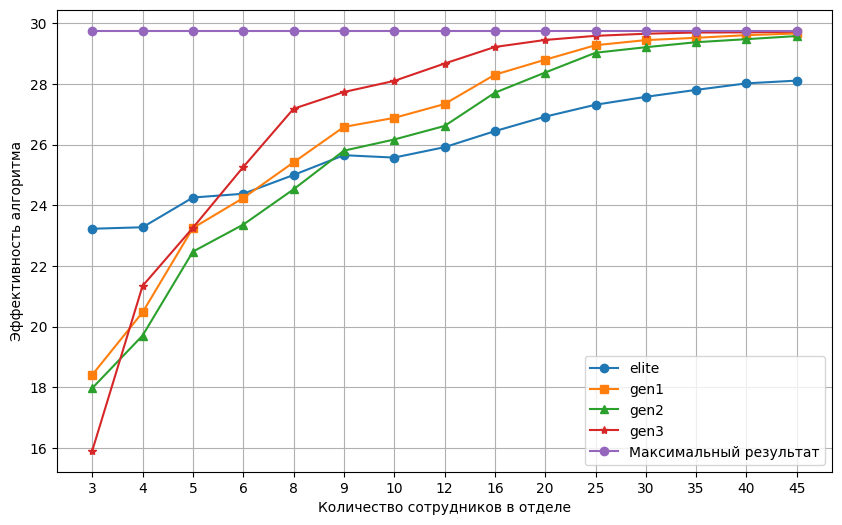

In [176]:
import matplotlib.pyplot as plt

# Пример данных (замените их на ваши массивы данных)
x = ['3', '4', '5', '6', '8', '9', '10', '12', '16', '20', '25', '30', '35', '40', '45']
y1 = res_el
y2 = res_g1
y3 = res_g2
y4 = res_g3
y5 = [29.75018 for _ in range(15)]


# Построение графика
plt.figure(figsize=(10, 6))  # Размер графика (ширина, высота)

# Построение линий
plt.plot(x, y1, marker='o', label='elite')
plt.plot(x, y2, marker='s', label='gen1')
plt.plot(x, y3, marker='^', label='gen2')
plt.plot(x, y4, marker='*', label='gen3')
plt.plot(x, y5, marker='o', label='Максимальный результат')

# Настройка осей и заголовка
plt.xlabel('Количество сотрудников в отделе')
plt.ylabel('Эффективность алгоритма')


# Добавление легенды
plt.legend()

# Отображение сетки на графике
plt.grid(True)

# Отображение графика
plt.savefig('C:\\Users\\Dmitriy\\python\\effectiveness_num_words.png', dpi=600)
plt.show()


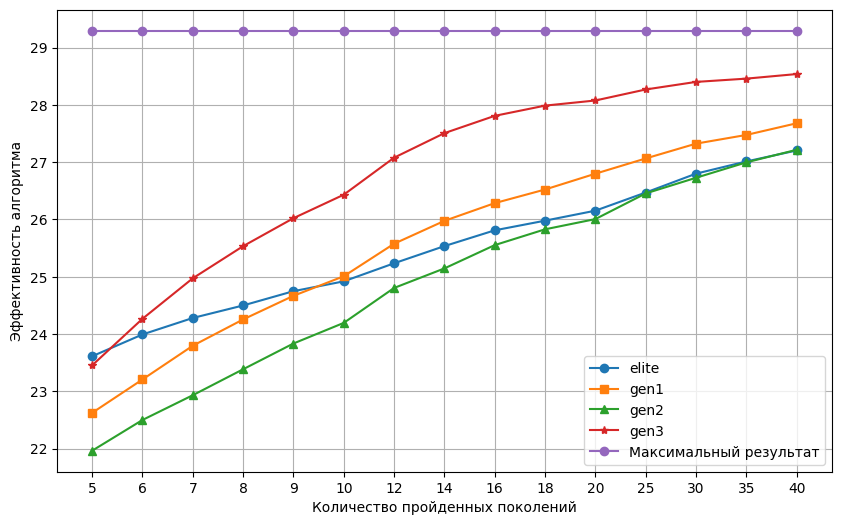

In [131]:
x = ['5', '6', '7', '8', '9', '10', '12', '14', '16', '18', '20', '25', '30', '35', '40']
y1 = res_el
y2 = res_g1
y3 = res_g2
y4 = res_g3
y5 = [29.2966 for _ in range(15)]
# Построение графика
plt.figure(figsize=(10, 6))  # Размер графика (ширина, высота)

# Построение линий
plt.plot(x, y1, marker='o', label='elite')
plt.plot(x, y2, marker='s', label='gen1')
plt.plot(x, y3, marker='^', label='gen2')
plt.plot(x, y4, marker='*', label='gen3')
plt.plot(x, y5, marker='o', label='Максимальный результат')

# Настройка осей и заголовка
plt.xlabel('Количество пройденных поколений')
plt.ylabel('Эффективность алгоритма')


# Добавление легенды
plt.legend()

# Отображение сетки на графике
plt.grid(True)

# Отображение графика
plt.savefig('C:\\Users\\Dmitriy\\python\\effectiveness_generations.png', dpi=600)
plt.show()

In [141]:
word_length_razbivka = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 20, 25, 30]

# automata_list = [generate_automata_class2() for i in range(30)]
# word_length = 10
generations = 15
num_words = 10
mutation_rate = 0.1
precision = 50
k = 0.5
c = 1
list_exhaustive = []

list_elite = []
list_gen1 = []
list_gen2 = []
list_gen3 = []
list_exhaustive = []
df = pd.DataFrame({'generations': [], 'elite': [], 'gen1': [], 'gen2': [], 'gen3': []})

map_length_el = {}
map_length_gen1 = {}
map_length_gen2 = {}
map_length_gen3 = {}

start_time = time.time()
for word_length in word_length_razbivka:
    how_many_from_old_population = int(num_words / 2)
    crossover_group = int(num_words / 2)
    sum_length_el = []
    sum_length_gen1 = []
    sum_length_gen2 = []
    sum_length_gen3 = []
    c = 1
    for automata in automata_list_copy:
        map = comparison(automata, word_length, generations, list(automata.alphabet.keys()), num_words, mutation_rate, how_many_from_old_population, precision, k, crossover_group)
        print(f'выполнено {c} автомат, {word_length} длина, времени затрачено:', time.time() - start_time)
        # list_elite.append((generations, map['elite'][0], map['elite'][1]))
        # list_gen1.append((generations, map['gen1'][0], map['gen1'][1]))
        # list_gen2.append((generations, map['gen2'][0], map['gen2'][1]))
        # list_gen3.append((map['gen3'][0], map['gen3'][1]))
        sum_length_el.append(map['elite'][0])
        sum_length_gen1.append(map['gen1'][0])
        sum_length_gen2.append(map['gen2'][0])
        sum_length_gen3.append(map['gen3'][0])
        # list_exhaustive.append((generations, exhaustive_research(automata, 10)[1]))
        df.loc[len(df.index)] = [f'automata{c}', str(map['elite'][0]) + '+-' + str(map['elite'][1]), str(map['gen1'][0]) + '+-' + str(map['gen1'][1]), str(map['gen2'][0]) + '+-' + str(map['gen2'][1]), str(map['gen3'][0]) + '+-' + str(map['gen3'][1])] 
        c+= 1
    map_length_el[word_length] = statistics.mean(sum_length_el)
    map_length_gen1[word_length] = statistics.mean(sum_length_gen1)
    map_length_gen2[word_length] = statistics.mean(sum_length_gen2)
    map_length_gen3[word_length] = statistics.mean(sum_length_gen3)

# for i in automata_list:
#     list_exhaustive.append(exhaustive_research(automata, 10)[1])

выполнено 1 автомат, 4 длина, времени затрачено: 0.44472408294677734
выполнено 2 автомат, 4 длина, времени затрачено: 0.8671319484710693
выполнено 3 автомат, 4 длина, времени затрачено: 1.3762121200561523
выполнено 4 автомат, 4 длина, времени затрачено: 1.803274154663086
выполнено 5 автомат, 4 длина, времени затрачено: 2.2551064491271973
выполнено 6 автомат, 4 длина, времени затрачено: 2.7149462699890137
выполнено 7 автомат, 4 длина, времени затрачено: 3.161870002746582
выполнено 8 автомат, 4 длина, времени затрачено: 3.609898090362549
выполнено 9 автомат, 4 длина, времени затрачено: 4.028348207473755
выполнено 10 автомат, 4 длина, времени затрачено: 4.476442575454712
выполнено 11 автомат, 4 длина, времени затрачено: 4.942854642868042
выполнено 12 автомат, 4 длина, времени затрачено: 5.360198259353638
выполнено 13 автомат, 4 длина, времени затрачено: 5.839528560638428
выполнено 14 автомат, 4 длина, времени затрачено: 6.265998125076294
выполнено 15 автомат, 4 длина, времени затрачено: 6

In [148]:
#### Вывод результатов исследования зависимости эффективности алгоритмов от количества поколений
from tabulate import tabulate
from IPython.display import display, HTML
word_length_razbivka = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 20, 25, 30]
res_el = []
res_g1 = []
res_g2 = []
res_g3 = []
for i in word_length_razbivka:
    res_el.append(round(map_length_el[i], 2))
    res_g1.append(round(map_length_gen1[i], 2))
    res_g2.append(round(map_length_gen2[i], 2))
    res_g3.append(round(map_length_gen3[i], 2))
data_frame = pd.DataFrame({'Длина стратегии': word_length_razbivka, 'elite': res_el, 'gen1': res_g1, 'gen2': res_g2, 'gen3': res_g3})


html = tabulate(data_frame, headers='keys', tablefmt='html', showindex=False)


display(HTML(html))
print(html)

Длина стратегии,elite,gen1,gen2,gen3
4,29.67,29.55,29.54,29.55
5,29.68,29.55,29.51,29.58
6,29.5,29.4,29.33,29.5
7,28.92,29.06,28.95,29.34
8,28.09,28.5,28.29,29.06
9,26.9,27.78,27.36,28.65
10,25.58,26.89,26.18,28.09
11,23.99,25.75,24.72,27.44
12,22.17,24.43,22.92,26.58
13,20.22,22.92,20.98,25.62


<table>
<thead>
<tr><th style="text-align: right;">  Длина стратегии</th><th style="text-align: right;">  elite</th><th style="text-align: right;">  gen1</th><th style="text-align: right;">  gen2</th><th style="text-align: right;">  gen3</th></tr>
</thead>
<tbody>
<tr><td style="text-align: right;">                4</td><td style="text-align: right;">  29.67</td><td style="text-align: right;"> 29.55</td><td style="text-align: right;"> 29.54</td><td style="text-align: right;"> 29.55</td></tr>
<tr><td style="text-align: right;">                5</td><td style="text-align: right;">  29.68</td><td style="text-align: right;"> 29.55</td><td style="text-align: right;"> 29.51</td><td style="text-align: right;"> 29.58</td></tr>
<tr><td style="text-align: right;">                6</td><td style="text-align: right;">  29.5 </td><td style="text-align: right;"> 29.4 </td><td style="text-align: right;"> 29.33</td><td style="text-align: right;"> 29.5 </td></tr>
<tr><td style="text-align: right;">    

In [146]:
print(res_g3)

[29.5496, 29.5753, 29.4951, 29.3417, 29.0557, 28.6464, 28.0872, 27.4382, 26.5783, 25.618199999999998, 23.3813, 16.3211, 8.8349, 1.714]


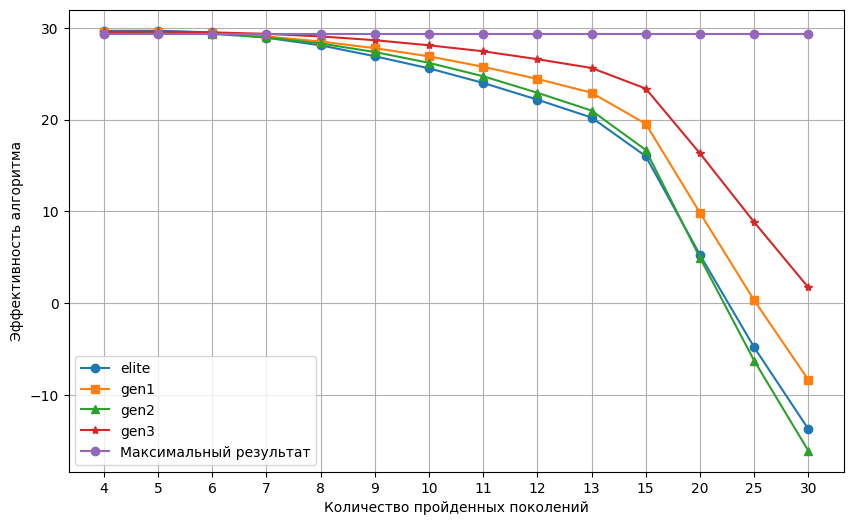

In [153]:
x = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 20, 25, 30]
x = [str(i) for i in word_length_razbivka]
y1 = res_el
y2 = res_g1
y3 = res_g2
y4 = res_g3
y5 = [29.2966 for _ in range(14)]
# Построение графика
plt.figure(figsize=(10, 6))  # Размер графика (ширина, высота)

# Построение линий
plt.plot(x, y1, marker='o', label='elite')
plt.plot(x, y2, marker='s', label='gen1')
plt.plot(x, y3, marker='^', label='gen2')
plt.plot(x, y4, marker='*', label='gen3')
plt.plot(x, y5, marker='o', label='Максимальный результат')

# Настройка осей и заголовка
plt.xlabel('Количество пройденных поколений')
plt.ylabel('Эффективность алгоритма')


# Добавление легенды
plt.legend()

# Отображение сетки на графике
plt.grid(True)

# Отображение графика
plt.savefig('C:\\Users\\Dmitriy\\python\\effectiveness_word_length.png', dpi=600)
plt.show()

In [157]:
mutation_rate_razbivka = [i / 10 for i in range(11)]

# automata_list = [generate_automata_class2() for i in range(30)]
word_length = 10
generations = 15
num_words = 10
# mutation_rate = 0.1
precision = 50
k = 0.5
c = 1
list_exhaustive = []

list_elite = []
list_gen1 = []
list_gen2 = []
list_gen3 = []
list_exhaustive = []
df = pd.DataFrame({'generations': [], 'elite': [], 'gen1': [], 'gen2': [], 'gen3': []})

map_mut_el = {}
map_mut_gen1 = {}
map_mut_gen2 = {}
map_mut_gen3 = {}

start_time = time.time()
for mutation_rate in mutation_rate_razbivka:
    how_many_from_old_population = int(num_words / 2)
    crossover_group = int(num_words / 2)
    sum_mut_el = []
    sum_mut_gen1 = []
    sum_mut_gen2 = []
    sum_mut_gen3 = []
    c = 1
    for automata in automata_list_copy:
        map = comparison(automata, word_length, generations, list(automata.alphabet.keys()), num_words, mutation_rate, how_many_from_old_population, precision, k, crossover_group)
        print(f'выполнено {c} автомат, {mutation_rate} длина, времени затрачено:', time.time() - start_time)
        # list_elite.append((generations, map['elite'][0], map['elite'][1]))
        # list_gen1.append((generations, map['gen1'][0], map['gen1'][1]))
        # list_gen2.append((generations, map['gen2'][0], map['gen2'][1]))
        # list_gen3.append((map['gen3'][0], map['gen3'][1]))
        sum_mut_el.append(map['elite'][0])
        sum_mut_gen1.append(map['gen1'][0])
        sum_mut_gen2.append(map['gen2'][0])
        sum_mut_gen3.append(map['gen3'][0])
        # list_exhaustive.append((generations, exhaustive_research(automata, 10)[1]))
        df.loc[len(df.index)] = [f'automata{c}', str(map['elite'][0]) + '+-' + str(map['elite'][1]), str(map['gen1'][0]) + '+-' + str(map['gen1'][1]), str(map['gen2'][0]) + '+-' + str(map['gen2'][1]), str(map['gen3'][0]) + '+-' + str(map['gen3'][1])] 
        c+= 1
    map_mut_el[mutation_rate] = statistics.mean(sum_mut_el)
    map_mut_gen1[mutation_rate] = statistics.mean(sum_mut_gen1)
    map_mut_gen2[mutation_rate] = statistics.mean(sum_mut_gen2)
    map_mut_gen3[mutation_rate] = statistics.mean(sum_mut_gen3)

# for i in automata_list:
#     list_exhaustive.append(exhaustive_research(automata, 10)[1])

выполнено 1 автомат, 0.0 длина, времени затрачено: 0.877985954284668
выполнено 2 автомат, 0.0 длина, времени затрачено: 1.8034014701843262
выполнено 3 автомат, 0.0 длина, времени затрачено: 2.795827865600586
выполнено 4 автомат, 0.0 длина, времени затрачено: 3.7917208671569824
выполнено 5 автомат, 0.0 длина, времени затрачено: 4.734591007232666
выполнено 6 автомат, 0.0 длина, времени затрачено: 5.673280715942383
выполнено 7 автомат, 0.0 длина, времени затрачено: 6.5946409702301025
выполнено 8 автомат, 0.0 длина, времени затрачено: 7.5103535652160645
выполнено 9 автомат, 0.0 длина, времени затрачено: 8.425235271453857
выполнено 10 автомат, 0.0 длина, времени затрачено: 9.326706409454346
выполнено 11 автомат, 0.0 длина, времени затрачено: 10.25049614906311
выполнено 12 автомат, 0.0 длина, времени затрачено: 11.173257112503052
выполнено 13 автомат, 0.0 длина, времени затрачено: 12.087853908538818
выполнено 14 автомат, 0.0 длина, времени затрачено: 13.007800340652466
выполнено 15 автомат, 

In [158]:
#### Вывод результатов исследования зависимости эффективности алгоритмов от количества поколений
from tabulate import tabulate
from IPython.display import display, HTML
mutation_rate_razbivka = [i / 10 for i in range(11)]
res_el = []
res_g1 = []
res_g2 = []
res_g3 = []
for i in mutation_rate_razbivka:
    res_el.append(round(map_mut_el[i], 2))
    res_g1.append(round(map_mut_gen1[i], 2))
    res_g2.append(round(map_mut_gen2[i], 2))
    res_g3.append(round(map_mut_gen3[i], 2))
data_frame = pd.DataFrame({'Вероятность мутации': mutation_rate_razbivka, 'elite': res_el, 'gen1': res_g1, 'gen2': res_g2, 'gen3': res_g3})


html = tabulate(data_frame, headers='keys', tablefmt='html', showindex=False)


display(HTML(html))
print(html)

Вероятность мутации,elite,gen1,gen2,gen3
0,25.63,26.31,25.5,27.74
0.1,25.67,26.84,26.17,27.88
0.2,25.67,27.23,26.64,28.03
0.3,25.66,27.42,26.97,28.08
0.4,25.62,27.66,27.23,28.17
0.5,25.64,27.78,27.43,28.2
0.6,25.63,27.91,27.57,28.21
0.7,25.64,28.01,27.7,28.23
0.8,25.65,28.05,27.79,28.25
0.9,25.66,28.11,27.83,28.24


<table>
<thead>
<tr><th style="text-align: right;">  Вероятность мутации</th><th style="text-align: right;">  elite</th><th style="text-align: right;">  gen1</th><th style="text-align: right;">  gen2</th><th style="text-align: right;">  gen3</th></tr>
</thead>
<tbody>
<tr><td style="text-align: right;">                  0  </td><td style="text-align: right;">  25.63</td><td style="text-align: right;"> 26.31</td><td style="text-align: right;"> 25.5 </td><td style="text-align: right;"> 27.74</td></tr>
<tr><td style="text-align: right;">                  0.1</td><td style="text-align: right;">  25.67</td><td style="text-align: right;"> 26.84</td><td style="text-align: right;"> 26.17</td><td style="text-align: right;"> 27.88</td></tr>
<tr><td style="text-align: right;">                  0.2</td><td style="text-align: right;">  25.67</td><td style="text-align: right;"> 27.23</td><td style="text-align: right;"> 26.64</td><td style="text-align: right;"> 28.03</td></tr>
<tr><td style="text-ali

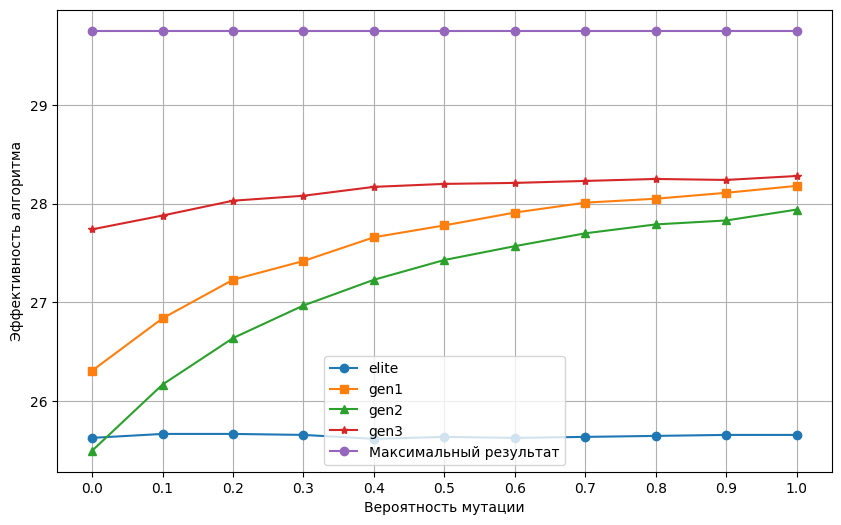

In [161]:
x = [i / 10 for i in range(11)]
x = [str(i) for i in x]
y1 = res_el
y2 = res_g1
y3 = res_g2
y4 = res_g3
y5 = [29.75 for _ in range(11)]
# Построение графика
plt.figure(figsize=(10, 6))  # Размер графика (ширина, высота)

# Построение линий
plt.plot(x, y1, marker='o', label='elite')
plt.plot(x, y2, marker='s', label='gen1')
plt.plot(x, y3, marker='^', label='gen2')
plt.plot(x, y4, marker='*', label='gen3')
plt.plot(x, y5, marker='o', label='Максимальный результат')

# Настройка осей и заголовка
plt.xlabel('Вероятность мутации')
plt.ylabel('Эффективность алгоритма')


# Добавление легенды
plt.legend()

# Отображение сетки на графике
plt.grid(True)

# Отображение графика
plt.savefig('C:\\Users\\Dmitriy\\python\\effectiveness_mutation_rate.png', dpi=600)
plt.show()